In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype
from pandas.api.types import is_string_dtype
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,average_precision_score,recall_score,f1_score,roc_auc_score,precision_score,roc_curve, auc
from imblearn.over_sampling import RandomOverSampler
import pickle


In [5]:
df = pd.read_csv('Copper_Set.csv')
df.head()

C:\Users\User\AppData\Local\Temp\ipykernel_12232\1295478384.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Copper_Set.csv')


,id,item_date,quantity tons,customer,country,status,item type,application,thickness,width,material_ref,product_ref,delivery date,selling_price
0,EC06F063-9DF0-440C-8764-0B0C05A4F6AE,20210401.0,54.151139,30156308.0,28.0,Won,W,10.0,2.00,1500.0,DEQ1 S460MC,1670798778,20210701.0,854.00
1,4E5F4B3D-DDDF-499D-AFDE-A3227EC49425,20210401.0,768.024839,30202938.0,25.0,Won,W,41.0,0.80,1210.0,0000000000000000000000000000000000104991,1668701718,20210401.0,1047.00
2,E140FF1B-2407-4C02-A0DD-780A093B1158,20210401.0,386.127949,30153963.0,30.0,Won,WI,28.0,0.38,952.0,S0380700,628377,20210101.0,644.33
3,F8D507A0-9C62-4EFE-831E-33E1DA53BB50,20210401.0,202.411065,30349574.0,32.0,Won,S,59.0,2.30,1317.0,DX51D+ZM310MAO 2.3X1317,1668701718,20210101.0,768.00
4,4E1C4E78-152B-430A-8094-ADD889C9D0AD,20210401.0,785.526262,30211560.0,28.0,Won,W,10.0,4.00,2000.0,2_S275JR+AR-CL1,640665,20210301.0,577.00


In [7]:
df1 = df.copy()
df1.shape
df1.columns
df1.info()
df1.isnull().sum()
#finding columns conation null value more than 55%
def data_cleaning(data):
    total_row = data.shape[0]
    total_col = data.shape[1]
    null_col = (data.isnull().sum(axis=0)/total_col)
    null_row = (data.isnull().sum(axis=1)/total_row)
    null_col = pd.Series(null_col)
    null_row = pd.Series(null_row)
    high_missing_cols = null_col[null_col >= 55]
    high_missing_row = null_row[null_row >= 55]
    if len(high_missing_cols) > 0:
        return "ATTENTION, More than 55% missing values in following column(s): " + ", ".join(high_missing_cols.index)
    if len(high_missing_row) > 0:
        return "ATTENTION, More than 55% missing values in following row(s): " + ", ".join(high_missing_row.index)
    else:
        return "No Missing Values Found",data
    
data_cleaning(df1)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181673 entries, 0 to 181672
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             181671 non-null  object 
 1   item_date      181672 non-null  float64
 2   quantity tons  181673 non-null  object 
 3   customer       181672 non-null  float64
 4   country        181645 non-null  float64
 5   status         181671 non-null  object 
 6   item type      181673 non-null  object 
 7   application    181649 non-null  float64
 8   thickness      181672 non-null  float64
 9   width          181673 non-null  float64
 10  material_ref   103754 non-null  object 
 11  product_ref    181673 non-null  int64  
 12  delivery date  181672 non-null  float64
 13  selling_price  181672 non-null  float64
dtypes: float64(8), int64(1), object(5)
memory usage: 19.4+ MB


'ATTENTION, More than 55% missing values in following column(s): material_ref'

In [8]:
#drop the column material_ref and id column because of all unique value
df1.drop(columns=['id','material_ref'], inplace=True)
df1.head()

,item_date,quantity tons,customer,country,status,item type,application,thickness,width,product_ref,delivery date,selling_price
0,20210401.0,54.151139,30156308.0,28.0,Won,W,10.0,2.00,1500.0,1670798778,20210701.0,854.00
1,20210401.0,768.024839,30202938.0,25.0,Won,W,41.0,0.80,1210.0,1668701718,20210401.0,1047.00
2,20210401.0,386.127949,30153963.0,30.0,Won,WI,28.0,0.38,952.0,628377,20210101.0,644.33
3,20210401.0,202.411065,30349574.0,32.0,Won,S,59.0,2.30,1317.0,1668701718,20210101.0,768.00
4,20210401.0,785.526262,30211560.0,28.0,Won,W,10.0,4.00,2000.0,640665,20210301.0,577.00


In [9]:
df1['quantity tons'] = pd.to_numeric(df1['quantity tons'], errors='coerce')
df1['item_date'] = pd.to_datetime(df1['item_date'], format='%Y%m%d',errors='coerce')
df1['delivery date'] = pd.to_datetime(df1['delivery date'], format='%Y%m%d',errors='coerce')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181673 entries, 0 to 181672
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   item_date      181670 non-null  datetime64[ns]
 1   quantity tons  181672 non-null  float64       
 2   customer       181672 non-null  float64       
 3   country        181645 non-null  float64       
 4   status         181671 non-null  object        
 5   item type      181673 non-null  object        
 6   application    181649 non-null  float64       
 7   thickness      181672 non-null  float64       
 8   width          181673 non-null  float64       
 9   product_ref    181673 non-null  int64         
 10  delivery date  181670 non-null  datetime64[ns]
 11  selling_price  181672 non-null  float64       
dtypes: datetime64[ns](2), float64(7), int64(1), object(2)
memory usage: 16.6+ MB


In [10]:
df1.describe()

,item_date,quantity tons,customer,country,application,thickness,width,product_ref,delivery date,selling_price
count,181670,1.816720e+05,1.816720e+05,181645.000000,181649.000000,181672.000000,181673.000000,1.816730e+05,181670,1.816720e+05
mean,2020-11-26 22:56:58.127374080,5.874926e+03,3.051221e+07,44.893022,25.615809,2.564827,1295.286724,4.739679e+08,2021-01-25 22:44:26.223372032,1.918036e+03
min,2020-07-02 00:00:00,-2.000000e+03,1.245800e+04,25.000000,2.000000,0.180000,1.000000,6.117280e+05,2019-04-01 00:00:00,-1.160000e+03
25%,2020-09-29 00:00:00,1.097030e+01,3.019688e+07,26.000000,10.000000,0.700000,1180.000000,6.119930e+05,2020-11-01 00:00:00,6.690000e+02
50%,2020-11-30 00:00:00,3.036464e+01,3.020524e+07,30.000000,15.000000,1.500000,1250.000000,6.406650e+05,2021-01-01 00:00:00,8.120000e+02
75%,2021-02-03 00:00:00,6.716061e+01,3.028042e+07,78.000000,41.000000,3.000000,1500.000000,1.332077e+09,2021-04-01 00:00:00,9.530000e+02
max,2021-04-01 00:00:00,1.000000e+09,2.147484e+09,113.000000,99.000000,2500.000000,2990.000000,1.722208e+09,2022-01-01 00:00:00,1.000010e+08
std,NaN,2.349081e+06,2.433382e+07,24.404214,17.754175,6.572321,261.631754,7.175101e+08,NaN,3.317956e+05


In [11]:
df1['quantity tons'] = df1['quantity tons'].apply(lambda x: np.nan if x<=0 else x)
df1['selling_price'] = df1['selling_price'].apply(lambda x: np.nan if x<=0 else x)
df1.describe()

,item_date,quantity tons,customer,country,application,thickness,width,product_ref,delivery date,selling_price
count,181670,1.816680e+05,1.816720e+05,181645.000000,181649.000000,181672.000000,181673.000000,1.816730e+05,181670,1.816650e+05
mean,2020-11-26 22:56:58.127374080,5.875066e+03,3.051221e+07,44.893022,25.615809,2.564827,1295.286724,4.739679e+08,2021-01-25 22:44:26.223372032,1.918124e+03
min,2020-07-02 00:00:00,1.000000e-05,1.245800e+04,25.000000,2.000000,0.180000,1.000000,6.117280e+05,2019-04-01 00:00:00,1.000000e-01
25%,2020-09-29 00:00:00,1.097122e+01,3.019688e+07,26.000000,10.000000,0.700000,1180.000000,6.119930e+05,2020-11-01 00:00:00,6.690000e+02
50%,2020-11-30 00:00:00,3.036501e+01,3.020524e+07,30.000000,15.000000,1.500000,1250.000000,6.406650e+05,2021-01-01 00:00:00,8.120000e+02
75%,2021-02-03 00:00:00,6.716134e+01,3.028042e+07,78.000000,41.000000,3.000000,1500.000000,1.332077e+09,2021-04-01 00:00:00,9.530000e+02
max,2021-04-01 00:00:00,1.000000e+09,2.147484e+09,113.000000,99.000000,2500.000000,2990.000000,1.722208e+09,2022-01-01 00:00:00,1.000010e+08
std,NaN,2.349107e+06,2.433382e+07,24.404214,17.754175,6.572321,261.631754,7.175101e+08,NaN,3.318020e+05


In [12]:
df1.isnull().sum()

item_date         3
quantity tons     5
customer          1
country          28
status            2
item type         0
application      24
thickness         1
width             0
product_ref       0
delivery date     3
selling_price     8
dtype: int64

In [13]:
df1['item_date'] = df1['item_date'].fillna(df1['item_date'].mode().iloc[0])
df1['status'] = df1['status'].fillna(df1['status'].mode().iloc[0])
df1['delivery date'] = df1['delivery date'].fillna(df1['delivery date'].mode().iloc[0])


In [14]:
#numerical datatype using median
df1['quantity tons'] = df1['quantity tons'].fillna(df1['quantity tons'].median())
df1['customer'] = df1['customer'].fillna(df1['customer'].median())
df1['country'] = df1['country'].fillna(df1['country'].median())
df1['application'] = df1['application'].fillna(df1['application'].median())
df1['thickness'] = df1['thickness'].fillna(df1['thickness'].median())
df1['selling_price'] = df1['selling_price'].fillna(df1['selling_price'].median())
df1.isnull().sum()

item_date        0
quantity tons    0
customer         0
country          0
status           0
item type        0
application      0
thickness        0
width            0
product_ref      0
delivery date    0
selling_price    0
dtype: int64

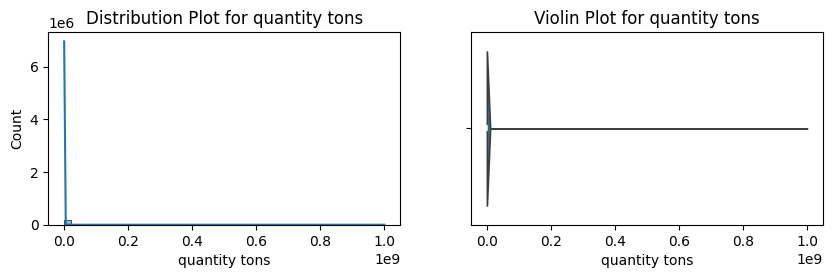

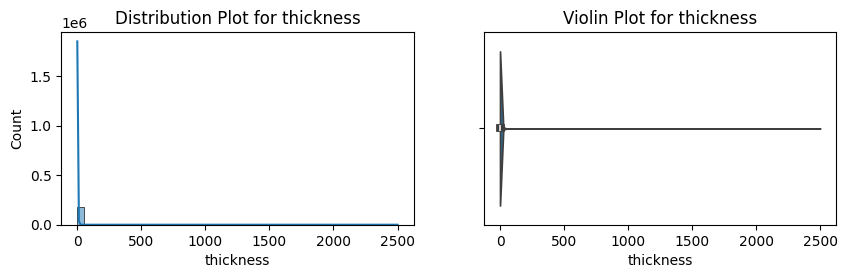

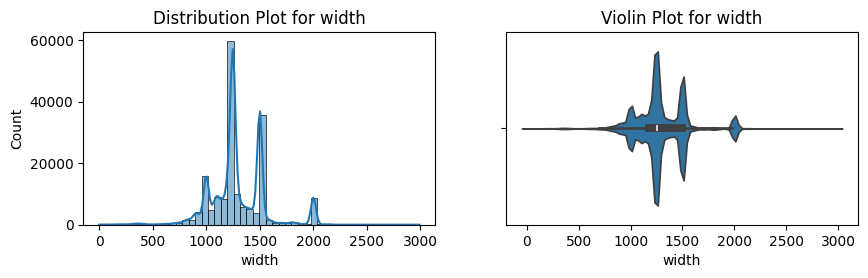

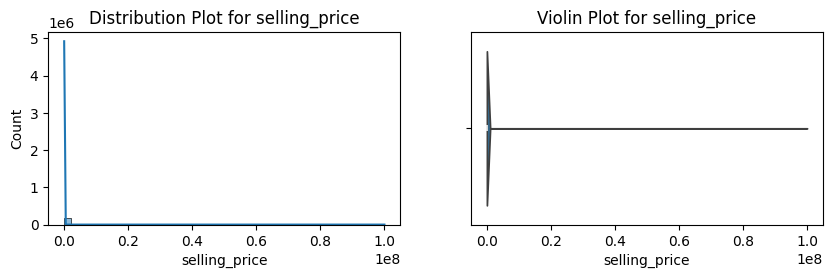

In [15]:
df2 = df1.copy()
#skew data detection
for column in ['quantity tons','thickness', 'width', 'selling_price']:   
    plt.figure(figsize=(10,2.5))
    plt.subplot(1,2,1)
    sns.histplot(data=df2, x=column, kde=True, bins=50)
    plt.title(f'Distribution Plot for {column}')

    plt.subplot(1,2,2)
    sns.violinplot(data=df2, x=column)
    plt.title(f'Violin Plot for {column}')
    plt.show()

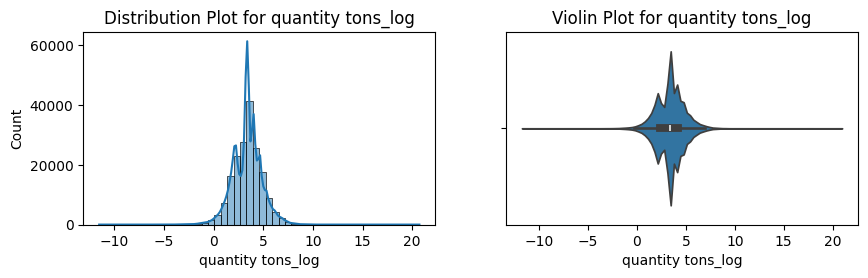

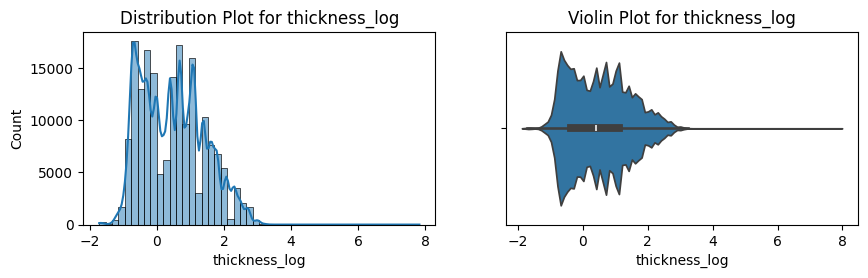

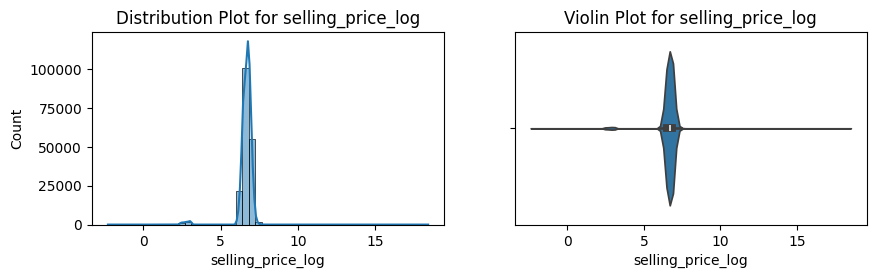

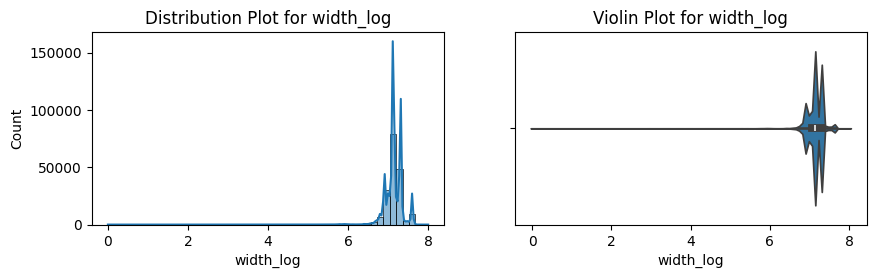

In [16]:
df2['quantity tons_log'] = np.log(df2['quantity tons'])
df2['thickness_log'] = np.log(df2['thickness'])
df2['selling_price_log'] = np.log(df2['selling_price'])
df2['width_log'] = np.log(df2['width'])

for column in ['quantity tons_log','thickness_log','selling_price_log','width_log']:   
    plt.figure(figsize=(10,2.5))
    plt.subplot(1,2,1)
    sns.histplot(data=df2, x=column, kde=True, bins=50)
    plt.title(f'Distribution Plot for {column}')

    plt.subplot(1,2,2)
    sns.violinplot(data=df2, x=column)
    plt.title(f'Violin Plot for {column}')
    plt.show()

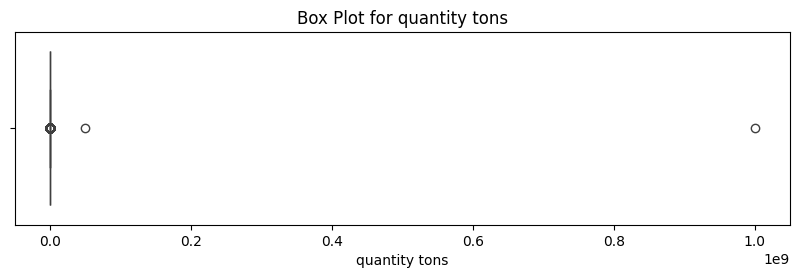

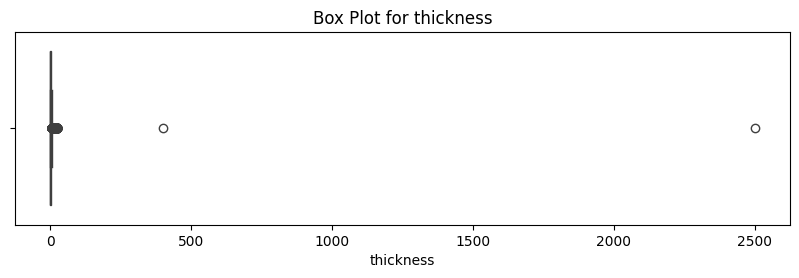

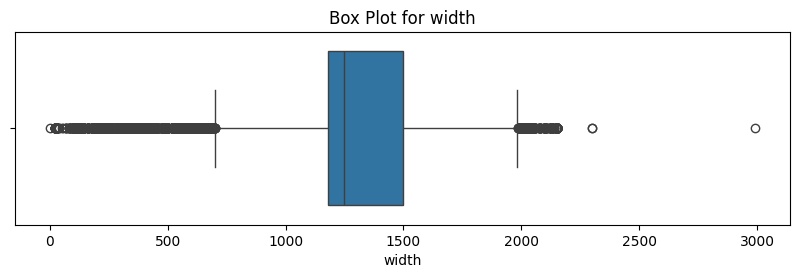

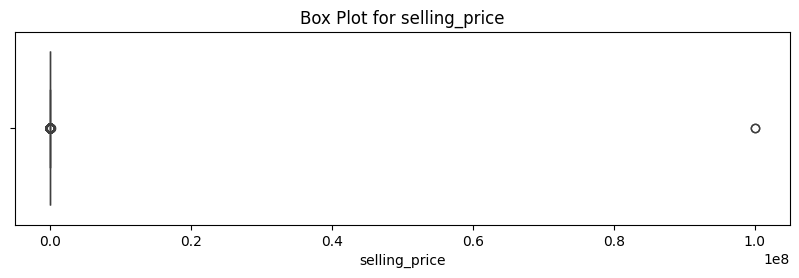

In [17]:
for column in ['quantity tons','thickness', 'width', 'selling_price']:
    plt.figure(figsize=(10,2.5))
    sns.boxplot(data=df2, x=column)
    plt.title(f'Box Plot for {column}')
    plt.show()


In [18]:
df3=df2.copy()

In [19]:
#Using IQR for outliers
def outlier(df, column):
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)
    upper_threshold = df[column].quantile(0.75) + (1.5*iqr)
    lower_threshold = df[column].quantile(0.25) - (1.5*iqr)
    df[column] = df[column].clip(lower_threshold, upper_threshold)

outlier(df3, 'quantity tons')
outlier(df3, 'thickness')
outlier(df3, 'selling_price')
outlier(df3, 'width')

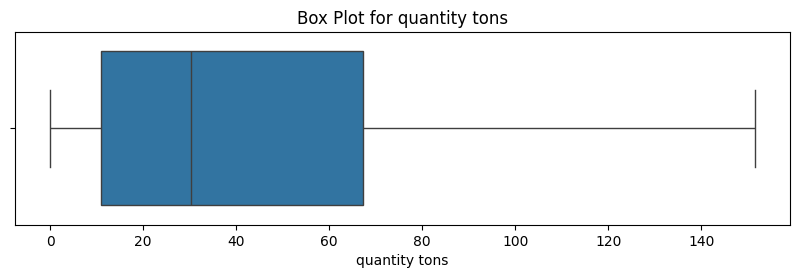

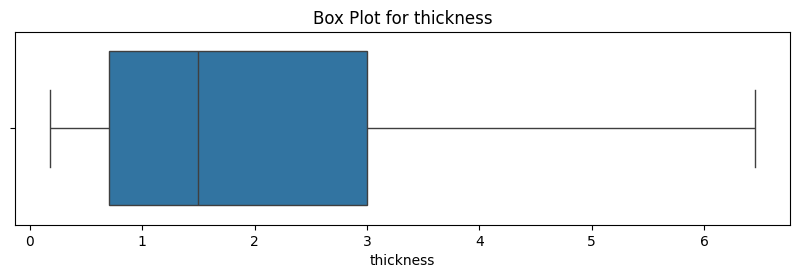

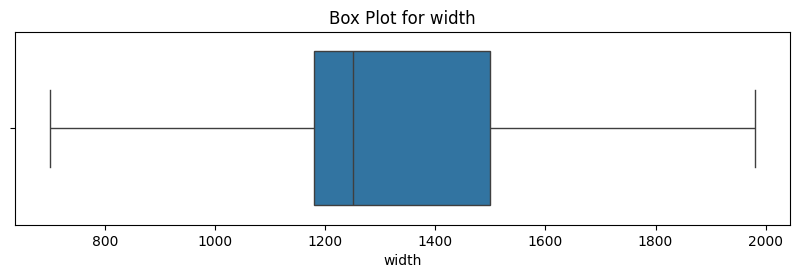

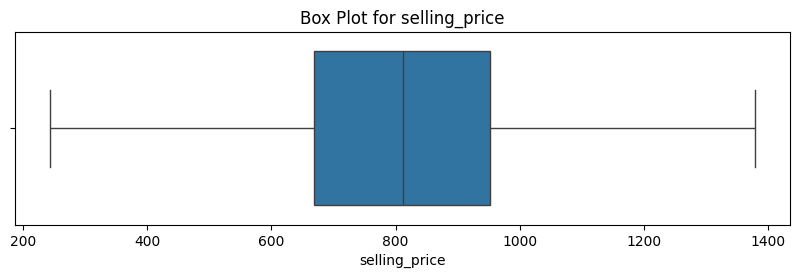

In [20]:
# box plot after outlier treatment
for column in ['quantity tons','thickness', 'width', 'selling_price']:
    plt.figure(figsize=(10,2.5))
    sns.boxplot(data=df3, x=column)
    plt.title(f'Box Plot for {column}')
    plt.show()

In [21]:
df3.describe()

,item_date,quantity tons,customer,country,application,thickness,width,product_ref,delivery date,selling_price,quantity tons_log,thickness_log,selling_price_log,width_log
count,181673,181673.000000,1.816730e+05,181673.000000,181673.000000,181673.000000,181673.000000,1.816730e+05,181673,181673.000000,181673.000000,181673.000000,181673.000000,181673.000000
mean,2020-11-26 22:57:05.323521024,49.175605,3.051221e+07,44.890727,25.614406,2.245427,1297.045583,4.739679e+08,2021-01-25 22:43:50.629757696,819.074374,3.392111,0.480372,6.625890,7.143386
min,2020-07-02 00:00:00,0.000010,1.245800e+04,25.000000,2.000000,0.180000,700.000000,6.117280e+05,2019-04-01 00:00:00,243.000000,-11.512925,-1.714798,-2.302585,0.000000
25%,2020-09-29 00:00:00,10.971669,3.019688e+07,26.000000,10.000000,0.700000,1180.000000,6.119930e+05,2020-11-01 00:00:00,669.000000,2.395316,-0.356675,6.505784,7.073270
50%,2020-11-30 00:00:00,30.365013,3.020524e+07,30.000000,15.000000,1.500000,1250.000000,6.406650e+05,2021-01-01 00:00:00,812.000000,3.413291,0.405465,6.699500,7.130899
75%,2021-02-03 00:00:00,67.160385,3.028042e+07,78.000000,41.000000,3.000000,1500.000000,1.332077e+09,2021-04-01 00:00:00,953.000000,4.207084,1.098612,6.859615,7.313220
max,2021-04-01 00:00:00,151.443459,2.147484e+09,113.000000,99.000000,6.450000,1980.000000,1.722208e+09,2022-01-01 00:00:00,1379.000000,20.723266,7.824046,18.420691,8.003029
std,NaN,47.991944,2.433375e+07,24.403034,17.753421,1.890707,248.961933,7.175101e+08,NaN,209.126521,1.444849,0.933770,0.565391,0.232891


<Axes: >

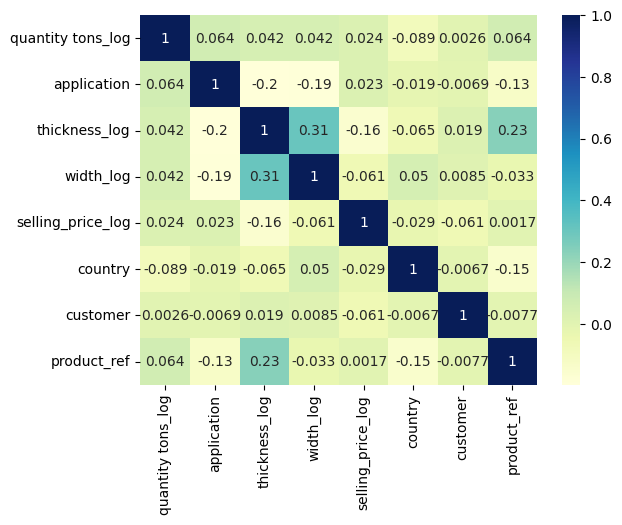

In [22]:
df_corr=df3[['quantity tons_log','application','thickness_log','width_log','selling_price_log','country','customer','product_ref']].corr()

sns.heatmap(df_corr, annot=True, cmap="YlGnBu")

In [27]:
df_ml = df3.copy()

In [28]:
df_ml.status.unique()

array(['Won', 'Draft', 'To be approved', 'Lost', 'Not lost for AM',
       'Wonderful', 'Revised', 'Offered', 'Offerable'], dtype=object)

In [29]:
df_ml['item type'].unique()

array(['W', 'WI', 'S', 'Others', 'PL', 'IPL', 'SLAWR'], dtype=object)

In [30]:
OE = OrdinalEncoder()
df_ml.status = OE.fit_transform(df_ml[['status']])
df_ml['item type'] = OE.fit_transform(df_ml[['item type']])

In [31]:
df_ml.status.unique()

array([7., 0., 6., 1., 2., 8., 5., 4., 3.])

In [32]:
df_ml['item type'].unique()

array([5., 6., 3., 1., 2., 0., 4.])

In [33]:
df_ml

,item_date,quantity tons,customer,country,status,item type,application,thickness,width,product_ref,delivery date,selling_price,quantity tons_log,thickness_log,selling_price_log,width_log
0,2021-04-01,54.151139,30156308.0,28.0,7.0,5.0,10.0,2.00,1500.0,1670798778,2021-07-01,854.00,3.991779,0.693147,6.749931,7.313220
1,2021-04-01,151.443459,30202938.0,25.0,7.0,5.0,41.0,0.80,1210.0,1668701718,2021-04-01,1047.00,6.643822,-0.223144,6.953684,7.098376
2,2021-04-01,151.443459,30153963.0,30.0,7.0,6.0,28.0,0.38,952.0,628377,2021-01-01,644.33,5.956169,-0.967584,6.468211,6.858565
3,2021-04-01,151.443459,30349574.0,32.0,7.0,3.0,59.0,2.30,1317.0,1668701718,2021-01-01,768.00,5.310301,0.832909,6.643790,7.183112
4,2021-04-01,151.443459,30211560.0,28.0,7.0,5.0,10.0,4.00,1980.0,640665,2021-03-01,577.00,6.666354,1.386294,6.357842,7.600902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181668,2020-07-02,102.482422,30200854.0,25.0,7.0,5.0,41.0,0.96,1220.0,164141591,2020-07-01,591.00,4.629691,-0.040822,6.381816,7.106606
181669,2020-07-02,151.443459,30200854.0,25.0,7.0,5.0,41.0,0.95,1500.0,164141591,2020-07-01,589.00,5.337954,-0.051293,6.378426,7.313220
181670,2020-07-02,4.235594,30200854.0,25.0,7.0,5.0,41.0,0.71,1250.0,164141591,2020-07-01,619.00,1.443523,-0.342490,6.428105,7.130899
181671,2020-07-02,30.365013,30200854.0,25.0,7.0,5.0,41.0,0.85,1250.0,164141591,2020-07-01,601.00,3.413291,-0.162519,6.398595,7.130899


In [34]:
A=df_ml[['quantity tons_log','status','item type','application','thickness_log','width_log','country','customer','product_ref']]
b=df_ml['selling_price_log']

In [35]:
SS = StandardScaler()
A = SS.fit_transform(A)

training & Tuning model for selling price prediction

In [37]:
A_train, A_test, b_train, b_test = train_test_split(A, b, test_size = 0.2, random_state = 5)
print(A_train.shape)
print(A_test.shape)
print(b_train.shape)
print(b_test.shape)

(145338, 9)
(36335, 9)
(145338,)
(36335,)


In [38]:
lr = LinearRegression()
lr.fit(A_train, b_train)
print(lr.score(A_train, b_train))
print(lr.score(A_test, b_test))

0.08662864873855403
0.0847652982457141


In [39]:
rf1 = RandomForestRegressor(n_estimators = 15, max_depth = 25, random_state = 30)
rf1.fit(A_train, b_train)
print(rf1.score(A_train, b_train))
print(rf1.score(A_test, b_test))

0.9821353462154706
0.9362000345312349


In [40]:
gbr = GradientBoostingRegressor(n_estimators = 10, learning_rate = 0.1, random_state =42)
gbr.fit(A_train, b_train)
print(gbr.score(A_train, b_train))
print(gbr.score(A_test, b_test))

0.7651796095650722
0.7732248300159084


In [41]:
dtr = DecisionTreeRegressor(max_depth = 10 ,max_features = 'log2',min_samples_split = 10, min_samples_leaf = 4)
dtr.fit(A_train, b_train)
print(dtr.score(A_train, b_train))
print(dtr.score(A_test, b_test))

0.8874943959989088
0.8926996490038347


In [42]:
def find_best_model(X,y):
    algos = {
        'linear_regression' : {
            'model' : LinearRegression(),
            'params' : {
                'n_jobs' : [1,2,5]
            }
        },
        'Random_Forest_Regressor' : {
            'model' : RandomForestRegressor(),
            'params' : {'n_estimators' : [15,30], 
                        'max_depth' : [15,25,30], 
                        'random_state' : [20,30,40]}
        },
        'decision_tree_regressor' : {
            'model' : DecisionTreeRegressor(),
            'params' : {'max_depth': [5, 10, 20],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['sqrt', 'log2']}
        },
        'Gradient_Boosting_Regressor' : {
            'model' : GradientBoostingRegressor(),
            'params' : {'n_estimators' : [10,15,20],
              'learning_rate' : [0.1],
              'random_state' :[20,42]
        }
     }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'],cv=cv)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return scores


In [43]:
find_best_model(A,b)

[{'model': 'linear_regression',
  'best_score': 0.08540431544288236,
  'best_params': {'n_jobs': 1}},
 {'model': 'Random_Forest_Regressor',
  'best_score': 0.933523245391713,
  'best_params': {'max_depth': 25, 'n_estimators': 30, 'random_state': 20}},
 {'model': 'decision_tree_regressor',
  'best_score': 0.9125579547255969,
  'best_params': {'max_depth': 20,
   'max_features': 'sqrt',
   'min_samples_leaf': 4,
   'min_samples_split': 2}},
 {'model': 'Gradient_Boosting_Regressor',
  'best_score': 0.8656020573168123,
  'best_params': {'learning_rate': 0.1,
   'n_estimators': 20,
   'random_state': 20}}]

In [44]:
A_train, A_test, b_train, b_test = train_test_split(A, b, test_size = 0.2, random_state = 42)

model = RandomForestRegressor(max_depth=25,random_state=20,n_estimators=30).fit(A_train, b_train)
A_train_pred = model.predict(A_train)
A_test_pred = model.predict(A_test)

mse_test = mean_squared_error(b_test, A_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(b_test, A_test_pred)
mae_test = mean_absolute_error(b_test, A_test_pred)

mse_train = mean_squared_error(b_train, A_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(b_train, A_train_pred)
mae_train = mean_absolute_error(b_train, A_train_pred)

train_metrics_r = {'R2': r2_train,
           'Mean Absolute Error': mae_train,
           'Mean Squared Error': mse_train,
           'Root Mean Squared Error': rmse_train}

test_metrics_r = {'R2': r2_test,
           'Mean Absolute Error': mae_test,
           'Mean Squared Error': mse_test,
           'Root Mean Squared Error': rmse_test}


train_metrics_r, test_metrics_r

({'R2': 0.9829870371555082,
  'Mean Absolute Error': 0.05095967940608996,
  'Mean Squared Error': 0.00547315036677592,
  'Root Mean Squared Error': 0.07398074321589315},
 {'R2': 0.9344534174935991,
  'Mean Absolute Error': 0.10471743010695564,
  'Mean Squared Error': 0.020418191961267436,
  'Root Mean Squared Error': 0.14289223898192455})

In [62]:
user_data = np.array([[np.log(151.4434585),7.0,5.0,41.0,-0.223,7.098,25.0,30202938.0,1668701718],[5.310301,7.0,3.0,59.0,0.832909,7.183112,32.0,30349574.0,1668701718]])
user_data = SS.fit_transform(user_data)
feature_names = ['quantity tons_log','status','item type','application','thickness_log','width_log','country','customer','product_ref']
df_userdata = pd.DataFrame(user_data, columns=feature_names)

y_pred = model.predict(user_data)

np.exp(y_pred)

array([974.51764336, 656.88562448])

In [63]:
with open('model_reggression.pkl','wb') as f:
    pickle.dump(model,f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(SS, f)

Classification Model Training

In [160]:
df_ml_cls = df3.copy()

In [161]:
df_ml_cls['status'].unique()

array(['Won', 'Draft', 'To be approved', 'Lost', 'Not lost for AM',
       'Wonderful', 'Revised', 'Offered', 'Offerable'], dtype=object)

In [162]:
df_ml_cls['item type'].unique()

array(['W', 'WI', 'S', 'Others', 'PL', 'IPL', 'SLAWR'], dtype=object)

In [163]:
df_ml_cls['status'] = df_ml_cls['status'].map({'Lost':0, 'Won':1, 'Draft':2, 'To be approved':3, 'Not lost for AM':4,
                                 'Wonderful':5, 'Revised':6, 'Offered':7, 'Offerable':8})
df_ml_cls['item type'] = df_ml_cls['item type'].map({'W':0, 'WI':1, 'S':2, 'Others':3, 'PL':4,
                                 'IPL':5, 'SLAWR':6})

In [164]:
df_ml_cls1 = df_ml_cls[df_ml_cls['status'].isin([0, 1])]
len(df_ml_cls1)

150450

In [82]:
df_ml_cls1.to_csv('df_cl.csv')

In [165]:
df_ml_cls1.status.value_counts()

status
1    116012
0     34438
Name: count, dtype: int64

In [166]:
new_x = df_ml_cls1[['quantity tons_log','selling_price_log','item type','application','thickness_log','width_log','country','customer','product_ref']]
new_y = df_ml_cls1['status']

ros = RandomOverSampler(sampling_strategy=1)
X, y = ros.fit_resample(new_x,new_y)

In [167]:
X.shape, y.shape

((232024, 9), (232024,))

In [168]:
y.value_counts()

status
1    116012
0    116012
Name: count, dtype: int64

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(185619, 9)
(46405, 9)
(185619,)
(46405,)


In [170]:
models=[
    DecisionTreeClassifier(),
    KNeighborsClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    LogisticRegression()
]


for c_model in models:
    c_model.fit(X_train, y_train)
    print(c_model)
    print(f'Train data score : {c_model.score(X_train, y_train)}')
    print(f'Test data score : {c_model.score(X_test, y_test)}')
    
    y_train_pred_c = c_model.predict(X_train)
    y_test_pred_c = c_model.predict(X_test)

    model_train_accuracy = accuracy_score(y_train, y_train_pred_c)
    model_train_f1 = f1_score(y_train, y_train_pred_c, average='weighted')
    model_train_precision = precision_score(y_train, y_train_pred_c)
    model_train_recall = recall_score(y_train, y_train_pred_c)


    model_test_accuracy = accuracy_score(y_test, y_test_pred_c)
    model_test_f1 = f1_score(y_test, y_test_pred_c, average='weighted')
    model_test_precision = precision_score(y_test, y_test_pred_c)
    model_test_recall = recall_score(y_test, y_test_pred_c)

    
    print('model performance for training set')
    print('accuracy: {:.4f}'.format(model_train_accuracy))
    print('f1 score: {:.4f}'.format(model_train_f1))
    print('precision: {:.4f}'.format(model_train_precision))
    print('recall: {:.4f}'.format(model_train_recall))
    print('\n')
    print('model performance for test set')
    print('accuracy: {:.4f}'.format(model_test_accuracy))
    print('f1 score: {:.4f}'.format(model_test_f1))
    print('precision: {:.4f}'.format(model_test_precision))
    print('recall: {:.4f}'.format(model_test_recall))

    print(f'-------------------')


DecisionTreeClassifier()
Train data score : 1.0
Test data score : 0.9672880077577847
model performance for training set
accuracy: 1.0000
f1 score: 1.0000
precision: 1.0000
recall: 1.0000


model performance for test set
accuracy: 0.9673
f1 score: 0.9673
precision: 0.9884
recall: 0.9455
-------------------
KNeighborsClassifier()
Train data score : 0.9525587359052683
Test data score : 0.930589376144812
model performance for training set
accuracy: 0.9526
f1 score: 0.9525
precision: 0.9851
recall: 0.9191


model performance for test set
accuracy: 0.9306
f1 score: 0.9305
precision: 0.9659
recall: 0.8922
-------------------
RandomForestClassifier()
Train data score : 0.9999892252409506
Test data score : 0.9727184570628165
model performance for training set
accuracy: 1.0000
f1 score: 1.0000
precision: 1.0000
recall: 1.0000


model performance for test set
accuracy: 0.9727
f1 score: 0.9727
precision: 0.9945
recall: 0.9505
-------------------
GradientBoostingClassifier()
Train data score : 0.77

In [171]:
param_grid = {'max_depth'        : [10, 20],
              'min_samples_split': [2, 5],
              'min_samples_leaf' : [1, 2],
              'max_features'     : ['sqrt', 'log2']}

grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f'best_score: {grid_search.best_score_}')
print(f'best_params: {grid_search.best_params_}')

best_score: 0.9533830117298076
best_params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2}


In [172]:
model_classifier = RandomForestClassifier(max_depth=20, max_features='log2', min_samples_leaf=1, min_samples_split=2).fit(X_train, y_train)
y_pred_train = model_classifier.predict(X_train)
y_pred_test = model_classifier.predict(X_test)
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
accuracy_train, accuracy_test

(0.9796410927760628, 0.9599396616743885)

In [174]:
y_pred = model_classifier.predict(X_test)

print(confusion_matrix(y_true=y_test, y_pred=y_pred))
print(classification_report(y_true=y_test, y_pred=y_pred))

[[23177   109]
 [ 1750 21369]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     23286
           1       0.99      0.92      0.96     23119

    accuracy                           0.96     46405
   macro avg       0.96      0.96      0.96     46405
weighted avg       0.96      0.96      0.96     46405



In [175]:
FP,TP,threshold = roc_curve(y_true=y_test, y_score=y_pred)
auc_curve = auc(x=FP, y=TP)
print(auc_curve)

0.9598118801491153


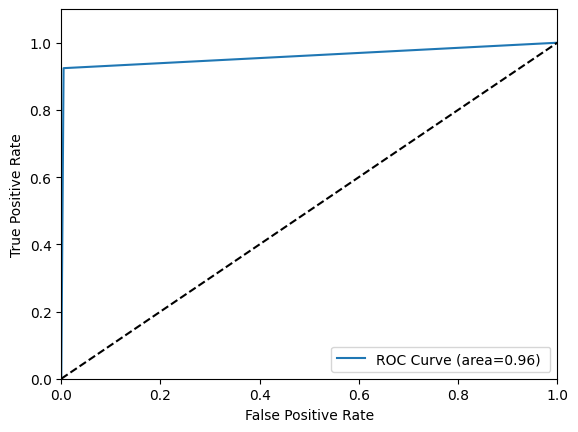

In [176]:
plt.plot(FP, TP, label=f"ROC Curve (area={round(auc_curve, 2)}) ")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.10])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [197]:
user_data_cl = np.array([[3.932944541,6.698268054,3.0,42.0,0.916290732,7.13089883,26.0,30223319,1668701376]])


feature_names1 = ['quantity tons_log','selling_price_log','item type','application','thickness_log','width_log','country','customer','product_ref']

df_userdata1 = pd.DataFrame(user_data_cl, columns=feature_names1)

y_p = model_classifier.predict(df_userdata1)
if y_p[0] == 1:
    print('Won')
else:
    print('Lose')


Lose


In [196]:
user_data_cl = np.array([[3.67765451,7.110696123,3.0,10.0,1.386294361,7.313220387,77.0,30165992,164141591]])
feature_names1 = ['quantity tons_log','selling_price_log','item type','application','thickness_log','width_log','country','customer','product_ref']

df_userdata1 = pd.DataFrame(user_data_cl, columns=feature_names1)

y_p = model_classifier.predict(df_userdata1)
if y_p[0] == 1:
    print('Won')
else:
    print('Lose')

Won


In [190]:
with open('model_classifier.pkl', 'wb') as file:
    pickle.dump(model_classifier, file)

Testing pickles

In [202]:
with open('model_reggression.pkl', 'rb') as f:
    model_r = pickle.load(f)
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

user_data = np.array([[np.log(151.4434585),7.0,5.0,41.0,-0.223,7.098,25.0,30202938.0,1668701718],[5.310301,7.0,3.0,59.0,0.832909,7.183112,32.0,30349574.0,1668701718]])
user_data = scaler.fit_transform(user_data)
feature_names = ['quantity tons_log','status','item type','application','thickness_log','width_log','country','customer','product_ref']
df_userdata = pd.DataFrame(user_data, columns=feature_names)

y_pred = model_r.predict(user_data)

np.exp(y_pred)

array([974.51764336, 656.88562448])

In [201]:
with open('model_classifier.pkl', 'rb') as f:
    model_c = pickle.load(f)

user_data_cl = np.array([[3.932944541,6.698268054,3.0,42.0,0.916290732,7.13089883,26.0,30223319,1668701376]])
feature_names1 = ['quantity tons_log','selling_price_log','item type','application','thickness_log','width_log','country','customer','product_ref']

df_userdata1 = pd.DataFrame(user_data_cl, columns=feature_names1)

pred = model.predict(df_userdata1)
if pred[0] == 1:
    print('Won')
else:
    print('Lose')

Lose
